# This feature was abandoned in 1.0.0. The env would crash as soon as the agent started moving.

In [ ]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk
!sudo apt-get install xvfb
!sudo apt-get install xserver-xephyr
!sudo apt-get install vnc4server
!sudo apt-get install python-opengl
!sudo apt-get install ffmpeg

In [ ]:
%%capture
!pip3 install pyvirtualdisplay
!pip3 install -U colabgymrender
!pip3 install imageio==2.4.1

In [ ]:
!pip3 install git+https://github.com/minerllabs/minerl

In [ ]:
import os

import numpy as np

import gym
#from gym.wrappers import Monitor
import minerl

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

from tqdm.notebook import tqdm
from colabgymrender.recorder import Recorder
from pyvirtualdisplay import Display

import logging
logging.disable(logging.ERROR) # reduce clutter, remove if something doesn't work to see the error logs.

import cv2
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

np.__version__  # '1.21.6' => that this is reading from our ~/mine_env directory

disp = Display(visible=0, backend="xvfb")
disp.start();

In [ ]:
# Copyright (c) 2020 All Rights Reserved
# Author: William H. Guss, Brandon Houghton

from minerl.herobraine.hero.handlers.agent.quit import AgentQuitFromPossessingItem
from minerl.herobraine.hero.handlers.agent.actions.equip import EquipAction
from minerl.herobraine.hero.mc import MS_PER_STEP, STEPS_PER_MS
from minerl.herobraine.env_specs.simple_embodiment import SimpleEmbodimentEnvSpec
from minerl.herobraine.env_specs.human_controls import HumanControlEnvSpec
from minerl.herobraine.hero.handler import Handler
from minerl.herobraine.hero import handlers
from typing import Dict, List, Optional, Union
from gym import spaces

none = 'none'
other = 'other'


def snake_to_camel(word):
    import re
    return ''.join(x.capitalize() or '_' for x in word.split('_'))


class Obtain(HumanControlEnvSpec):
    def __init__(self,
            target_item,
            dense,
            reward_schedule: List[Dict[str, Union[str, int, float]]],
            *args,
            max_episode_steps=6000,
            **kwargs):
        # 6000 for obtain iron  (5 mins)
        # 18000 for obtain diamond (15 mins)
        self.target_item = target_item
        self.dense = dense
        suffix = snake_to_camel(self.target_item)
        dense_suffix = "Dense" if self.dense else ""
        if self.dense:
            self.reward_text = "every time it obtains an item"
        else:
            self.reward_text = "only once per item the first time it obtains that item"
        self.reward_schedule = reward_schedule

        super().__init__(*args,
                name="MineRLObtain{}{}-v0".format(suffix, dense_suffix),
                max_episode_steps=max_episode_steps,
                **kwargs
                )

    def create_observables(self) -> List[Handler]:
        # TODO: Parameterize these observations.
        return super().create_observables() + [
            handlers.FlatInventoryObservation([
                'dirt',
                'coal',
                'torch',
                'log',
                'planks',
                'stick',
                'crafting_table',
                'wooden_axe',
                'wooden_pickaxe',
                'stone',
                'cobblestone',
                'furnace',
                'stone_axe',
                'stone_pickaxe',
                'iron_ore',
                'iron_ingot',
                'iron_axe',
                'iron_pickaxe'
            ]),
            handlers.EquippedItemObservation(items=[
                'air', 'wooden_axe', 'wooden_pickaxe', 'stone_axe', 'stone_pickaxe', 'iron_axe', 'iron_pickaxe', none,
                # TODO (R): REMOVE NONE FOR MINERL-v1
                other
            ], _default='air', _other=other),
        ]

    def create_actionables(self):
        # TODO (R): MineRL-v1 use invalid (for data)
        return super().create_actionables() + [
            handlers.PlaceBlock([none, 'dirt', 'stone', 'cobblestone', 'crafting_table', 'furnace', 'torch'],
                                _other=none, _default=none),
            handlers.EquipAction([none, 'air', 'wooden_axe', 'wooden_pickaxe', 'stone_axe', 'stone_pickaxe', 'iron_axe',
                                  'iron_pickaxe'], _other=none, _default=none),
            handlers.CraftAction([none, 'torch', 'stick', 'planks', 'crafting_table'], _other=none, _default=none),
            handlers.CraftNearbyAction(
                [none, 'wooden_axe', 'wooden_pickaxe', 'stone_axe', 'stone_pickaxe', 'iron_axe', 'iron_pickaxe',
                 'furnace'], _other=none, _default=none),
            handlers.SmeltItemNearby([none, 'iron_ingot', 'coal'], _other=none, _default=none),
            # As apart of pervious todo
            # this should be handlers.SmeltItem([none, 'iron_ingot', 'coal', other]), but this is not supported by mineRL-v0

        ]

    def create_rewardables(self) -> List[Handler]:
        reward_handler = (
            handlers.RewardForCollectingItems if self.dense
            else handlers.RewardForCollectingItemsOnce)

        return [
            reward_handler(self.reward_schedule if self.reward_schedule else {self.target_item: 1})
        ]

    def create_agent_start(self) -> List[Handler]:
        return []

    def create_agent_handlers(self) -> List[Handler]:
        return [
            handlers.AgentQuitFromPossessingItem([
                dict(type='diamond', amount=1)
            ])
        ]

    def create_server_world_generators(self) -> List[Handler]:
        return [handlers.DefaultWorldGenerator(force_reset=True)]

    def create_server_quit_producers(self) -> List[Handler]:
        return [
            handlers.ServerQuitFromTimeUp(time_limit_ms=
                                          self.max_episode_steps * MS_PER_STEP),
            handlers.ServerQuitWhenAnyAgentFinishes()]

    def create_server_decorators(self) -> List[Handler]:
        return []

    def create_server_initial_conditions(self) -> List[Handler]:
        return [
            handlers.TimeInitialCondition(
                start_time=6000,
                allow_passage_of_time=True,
            ),
            handlers.SpawningInitialCondition(
                allow_spawning=True
            )
        ]

    def is_from_folder(self, folder: str):
        return folder == 'o_{}'.format(self.target_item)

    def get_docstring(self):
        return ""

    def determine_success_from_rewards(self, rewards: list) -> bool:
        # TODO: Convert this to finish handlers.
        rewards = set(rewards)
        allow_missing_ratio = 0.1
        max_missing = round(len(self.reward_schedule) * allow_missing_ratio)

        # Get a list of the rewards from the reward_schedule.
        reward_values = [
            s['reward'] for s in self.reward_schedule
        ]

        return len(rewards.intersection(reward_values)) \
               >= len(reward_values) - max_missing


class ObtainDiamond(Obtain):

    def __init__(self, dense, *args, **kwargs):
        super(ObtainDiamond, self).__init__(*args,
            target_item='diamond',
            dense=dense,
            reward_schedule=[
                dict(type="log", amount=1, reward=1),
                dict(type="planks", amount=1, reward=2),
                dict(type="stick", amount=1, reward=4),
                dict(type="crafting_table", amount=1, reward=4),
                dict(type="wooden_pickaxe", amount=1, reward=8),
                dict(type="cobblestone", amount=1, reward=16),
                dict(type="furnace", amount=1, reward=32),
                dict(type="stone_pickaxe", amount=1, reward=32),
                dict(type="iron_ore", amount=1, reward=64),
                dict(type="iron_ingot", amount=1, reward=128),
                dict(type="iron_pickaxe", amount=1, reward=256),
                dict(type="diamond", amount=1, reward=1024)
            ],
            max_episode_steps=18000,
            **kwargs
            )

    def is_from_folder(self, folder: str) -> bool:
        return folder == 'o_dia'

    def get_docstring(self):
        return """
.. image:: ../assets/odia1.mp4.gif
  :scale: 100 %
  :alt:

.. image:: ../assets/odia2.mp4.gif
  :scale: 100 %
  :alt:

.. image:: ../assets/odia3.mp4.gif
  :scale: 100 %
  :alt:

.. image:: ../assets/odia4.mp4.gif
  :scale: 100 %
  :alt:

In this environment the agent is required to obtain a diamond.
The agent begins in a random starting location on a random survival map without any items, matching the normal starting conditions for human players in Minecraft.
The agent is given access to a selected summary of its inventory and GUI free
crafting, smelting, and inventory management actions.


During an episode **the agent is rewarded """ + self.reward_text + """**
in the requisite item hierarchy to obtaining a diamond. The rewards for each
item are given here::

    <Item reward="1" type="log" />
    <Item reward="2" type="planks" />
    <Item reward="4" type="stick" />
    <Item reward="4" type="crafting_table" />
    <Item reward="8" type="wooden_pickaxe" />
    <Item reward="16" type="cobblestone" />
    <Item reward="32" type="furnace" />
    <Item reward="32" type="stone_pickaxe" />
    <Item reward="64" type="iron_ore" />
    <Item reward="128" type="iron_ingot" />
    <Item reward="256" type="iron_pickaxe" />
    <Item reward="1024" type="diamond" />

\n"""


class ObtainIronPickaxe(Obtain):
    def __init__(self, dense, *args, **kwargs):
        super(ObtainIronPickaxe, self).__init__(*args,
            target_item='iron_pickaxe',
            dense=dense,
            reward_schedule=[
                dict(type="log", amount=1, reward=1),
                dict(type="planks", amount=1, reward=2),
                dict(type="stick", amount=1, reward=4),
                dict(type="crafting_table", amount=1, reward=4),
                dict(type="wooden_pickaxe", amount=1, reward=8),
                dict(type="cobblestone", amount=1, reward=16),
                dict(type="furnace", amount=1, reward=32),
                dict(type="stone_pickaxe", amount=1, reward=32),
                dict(type="iron_ore", amount=1, reward=64),
                dict(type="iron_ingot", amount=1, reward=128),
                dict(type="iron_pickaxe", amount=1, reward=256),
            ],
            **kwargs,
            )

    def create_agent_handlers(self):
        return [
            handlers.AgentQuitFromCraftingItem([
                dict(type="iron_pickaxe", amount=1)
            ])
        ]

    def is_from_folder(self, folder: str) -> bool:
        return folder == 'o_iron'

    def get_docstring(self):
        return """
.. image:: ../assets/orion1.mp4.gif
  :scale: 100 %
  :alt:

.. image:: ../assets/orion2.mp4.gif
  :scale: 100 %
  :alt:

.. image:: ../assets/orion3.mp4.gif
  :scale: 100 %
  :alt:

.. image:: ../assets/orion4.mp4.gif
  :scale: 100 %
  :alt:
In this environment the agent is required to obtain an iron pickaxe. The agent begins in a random starting location, on a random survival map, without any items, matching the normal starting conditions for human players in Minecraft.
The agent is given access to a selected view of its inventory and GUI free
crafting, smelting, and inventory management actions.


During an episode **the agent is rewarded """ + self.reward_text + """**
in the requisite item hierarchy for obtaining an iron pickaxe. The reward for each
item is given here::
    <Item amount="1" reward="1" type="log" />
    <Item amount="1" reward="2" type="planks" />
    <Item amount="1" reward="4" type="stick" />
    <Item amount="1" reward="4" type="crafting_table" />
    <Item amount="1" reward="8" type="wooden_pickaxe" />
    <Item amount="1" reward="16" type="cobblestone" />
    <Item amount="1" reward="32" type="furnace" />
    <Item amount="1" reward="32" type="stone_pickaxe" />
    <Item amount="1" reward="64" type="iron_ore" />
    <Item amount="1" reward="128" type="iron_ingot" />
    <Item amount="1" reward="256" type="iron_pickaxe" />

\n"""


# TODO: Deal with this boy.
class ObtainDiamondSurvival(ObtainDiamond):
    def __init__(self, dense):
        super(ObtainDiamondSurvival, self).__init__(dense)
        self.name = "MineRLObtainDiamondSurvival-v0"

    def is_from_folder(self, folder: str):
        return folder == 'none'


class ObtainDiamondDebug(ObtainDiamond):
    def __init__(self, dense):
        super().__init__(dense=dense)

        self.name = "MineRLObtainTest{}-v0".format('' if not dense else 'Dense')

    def create_actionables(self):
        actions = super().create_actionables()
        # Add a red flower to the equip action by replacing it with a new one
        equip_item = [a for a in actions if isinstance(a, handlers.EquipAction)][0]
        actions[actions.index(equip_item)] = (
            handlers.EquipAction(equip_item.items + ['red_flower'], _other=none, _default=none)
        )
        place_action = [a for a in actions if isinstance(a, handlers.PlaceBlock)][0]
        actions[actions.index(place_action)] = (
            handlers.PlaceBlock(place_action.items + ['log', 'diamond_ore'], _other=none, _default=none)
        )
        return actions

    def create_server_world_generators(self):
        return [
            handlers.FlatWorldGenerator(force_reset=True)
        ]

    def create_agent_start(self) -> List[Handler]:
        return [
            handlers.SimpleInventoryAgentStart([
                dict(type='dirt', quantity=1),
                dict(type='planks', quantity=3),
                dict(type='log', quantity=5),
                dict(type='iron_ore', quantity=4),
                dict(type='diamond_ore', quantity=1),
                dict(type='cobblestone', quantity=17),
                dict(type='red_flower', quantity=1),

            ])
        ]

    def create_agent_handlers(self) -> List[Handler]:
        return [
            AgentQuitFromPossessingItem([
                dict(type='diamond', amount=2)
            ])
        ]

    def is_from_folder(self, folder: str):
        return False

    def get_docstring(self):
        return """This environment intended for continuous integration testing only!!"""

In [ ]:
import gym

from minerl.herobraine.env_spec import EnvSpec

#MINERL_MY_TEST_V0 = MyTestlEnvSpec_2()
#MINERL_MY_TREECHOP_V0 = MyTreechop()
ObtainDiamondSurvival_v0 = ObtainDiamondSurvival(False)

# Register the envs.
ENVS = [env for env in locals().values() if isinstance(env, EnvSpec)]
for env in ENVS:
    if env.name not in gym.envs.registry.env_specs:
        env.register()

In [ ]:
env = gym.make('MineRLObtainDiamondSurvival-v0')

In [ ]:
import time

t0=time.time()
obs = env.reset()  # First obs is thrown away...
print(f"{(time.time()-t0):.2f}sec for env.reset")
# 275.65sec = 4mins for first time, 80.73sec second time (due to compilation of java files?)

In [ ]:
env.action_space.sample().keys()

odict_keys(['ESC', 'attack', 'back', 'camera', 'craft', 'drop', 'forward', 'hotbar.1', 'hotbar.2', 'hotbar.3', 'hotbar.4', 'hotbar.5', 'hotbar.6', 'hotbar.7', 'hotbar.8', 'hotbar.9', 'inventory', 'jump', 'left', 'pickItem', 'right', 'sneak', 'sprint', 'swapHands', 'use'])

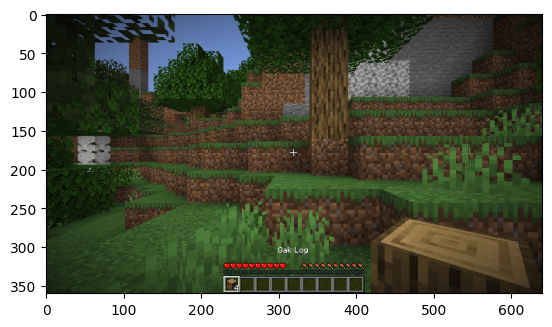

In [ ]:
plt.imshow(obs['pov'])

4.70sec for env.step


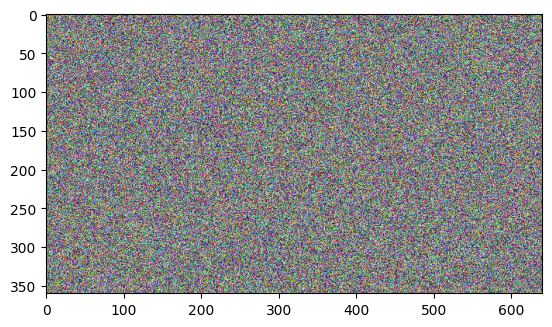

'5.00sec for whole spin'

In [ ]:
# Now that Steve has been spawned, do some actions...
t0=time.time()
img_array = []

done, iter = False, 0
while not done:
    ac = env.action_space.noop()
    # Spin around to see what is around us
    ac["camera"] = [0, +30]  # (pitch, yaw) deltas in degrees : +30 => turn to right

    t1=time.time()
    obs, reward, done, info = env.step(ac)
    #print(obs, reward, info)  # NB: Yikes : obs is only the image!
    #  obs = Dict(pov:Box(low=0, high=255, shape=(360, 640, 3)))
    #print(pov.shape) # (360, 640, 3)  Image spec agrees with docs!
    print(f"{(time.time()-t1):.2f}sec for env.step")  # Approx 0.25sec per step

    pov = obs["pov"]

    #env.render()  # This does an internal cv2.imshow that colab rejects
    #cv2_imshow(pov[:, :, ::-1])
    #cv2.waitKey(1)

    plt.imshow(pov)
    plt.show()

    img_array.append(pov)

    iter +=1
    if iter>20: done=True

f"{(time.time()-t0):.2f}sec for whole spin"

#1

In [ ]:
%%capture
!sudo add-apt-repository -y ppa:openjdk-r/ppa
!sudo apt-get purge openjdk-*
!sudo apt-get install openjdk-8-jdk
!sudo apt-get install xvfb
!sudo apt-get install xserver-xephyr
!sudo apt-get install vnc4server
!sudo apt-get install python-opengl
!sudo apt-get install ffmpeg

In [ ]:
%%capture
!pip3 install pyvirtualdisplay
!pip3 install -U colabgymrender
!pip3 install imageio==2.4.1

In [ ]:
%%capture
!python -m pip install --upgrade pip wheel==0.38.4 setuptools==65.6.1

In [ ]:
!pip3 install minerl==0.4.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
  Obtaining dependency information for dill>=0.3.1.1 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00
  Obtaining dependency information for jedi>=0.16 from https://files.pythonhosted.org/packages/8e/46/7e3ae3aa2dcfcffc5138c6cef5448523218658411c84a2000bf75c8d3ec1/jedi-0.19.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.3 MB/s eta

In [ ]:
import os

import numpy as np

import gym
#from gym.wrappers import Monitor
import minerl

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline

from tqdm.notebook import tqdm
from colabgymrender.recorder import Recorder
from pyvirtualdisplay import Display

import logging
logging.disable(logging.ERROR) # reduce clutter, remove if something doesn't work to see the error logs.

import cv2
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

np.__version__  # '1.21.6' => that this is reading from our ~/mine_env directory

/usr/local/lib/python3.10/dist-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


'1.22.4'

In [ ]:
# Get data
minerl.data.download(directory='data', environment='MineRLObtainDiamondDense-v0')
data = minerl.data.make("MineRLObtainDiamondDense-v0", data_dir='data', num_workers=2)

Download: https://minerl.s3.amazonaws.com/v4/MineRLObtainDiamondDense-v0.tar: 3650.0MB [03:49, 15.94MB/s]


In [ ]:
# Get data
minerl.data.download(directory='data', environment='MineRLObtainDiamond-v0')
data2 = minerl.data.make("MineRLObtainDiamond-v0", data_dir='data', num_workers=2)

Download: https://minerl.s3.amazonaws.com/v4/MineRLObtainDiamond-v0.tar: 3650.0MB [01:33, 39.12MB/s]                                


In [ ]:
record= []

In [ ]:
from minerl.data import BufferedBatchIter
#data = minerl.data.make('MineRLObtainDiamond-v0')
iterator = BufferedBatchIter(data)
n = 0
for current_state, action, reward, next_state, done \
    in iterator.buffered_batch_iter(batch_size=1, num_epochs=1):

        record.append(current_state['pov'])
        n += 1

        if n >= 2000:
            break

100%|██████████| 35479/35479 [00:03<00:00, 11612.80it/s]


In [ ]:
record = record[0]

In [ ]:
record.size()

AttributeError: ignored

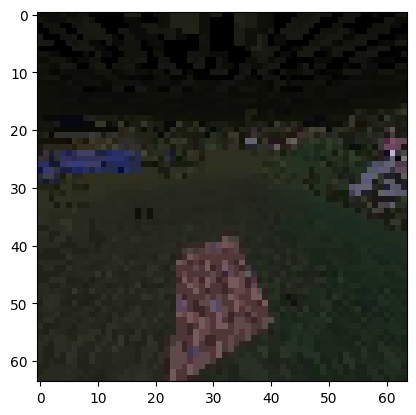

In [ ]:
plt.imshow(record[3][0])

In [ ]:
import os
# import cv2

file_path='saveVideo.mp4'
size=(64,64)
fps = 20

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videoWriter = cv2.VideoWriter(file_path,fourcc,fps,size)

for item in record:
    b, g, r = cv2.split(item)
    img = cv2.merge([r, g, b])
    #img = cv2.resize(img, size)
    #img = cv2.imread(item)
    videoWriter.write(img)

videoWriter.release()

##1

In [ ]:
import os
from collections import defaultdict
import numpy as np
import minerl
import time
from typing import List
import collections
import os
import cv2
import gym
from minerl.data import DataPipeline
import sys
import time
from collections import deque, defaultdict
from enum import Enum

mapping = dict()

def register(name):
    def _thunk(func):
        mapping[name] = func
        return func
    return _thunk


def get_discretizer(name):
    if callable(name):
        return name
    elif name in mapping:
        return mapping[name]
    else:
        raise ValueError('Registered wrappers:', ', '.join(mapping.keys()))


class LoopCraftingAgent:
    """
    Agent that acts according to the chain
    """
    def __init__(self, crafting_actions):
        """
        :param crafting_actions: list of crafting actions list({},...)
        """
        self.crafting_actions = crafting_actions
        self.current_action_index = 0

    def get_crafting_action(self):
        """
        :return: action to be taken
        """
        if len(self.crafting_actions) == 0:
            return {}

        result = self.crafting_actions[self.current_action_index]

        # move the pointer to the next action in the list
        self.current_action_index = (self.current_action_index + 1) % len(self.crafting_actions)

        return result

    def reset_index(self):
        self.current_action_index = 0


class CraftInnerWrapper(gym.Wrapper):
    """
    Wrapper for crafting actions
    """
    def __init__(self, env, crafts_agent):
        """
        :param env: env to wrap
        :param crafts_agent: instance of LoopCraftingAgent
        """
        super().__init__(env)
        self.crafts_agent = crafts_agent

    def step(self, action):
        """
        mix craft action with POV action
        :param action: POV action
        :return:
        """
        craft_action = self.crafts_agent.get_crafting_action()
        action = {**action, **craft_action}
        observation, reward, done, info = self.env.step(action)

        return observation, reward, done, info


class ObtainPoVWrapper(gym.ObservationWrapper):
    """Obtain 'pov' value (current game display) of the original observation."""
    def __init__(self, env):
        super().__init__(env)

        self.observation_space = self.env.observation_space.spaces['pov']

    def observation(self, observation):
        #return observation['pov']
        return observation


class DiscreteBase(gym.Wrapper):
    def __init__(self, env):
        super(DiscreteBase, self).__init__(env)
        self.action_dict = {}
        self.action_space = gym.spaces.Discrete(len(self.action_dict))

    def step(self, action):
        #print("self.action_dict[action]: " + str(self.action_dict[action]))
        s, r, done, info = self.env.step(self.action_dict[action])
        return s, r, done, info

    def sample_action(self):
        return self.action_space.sample()


class ItemAgentNode:
    """
    combined info about each agent
    """
    def __init__(self, node_name, count_, pov_agent, crafting_agent):
        self.name = node_name
        self.count = count_
        self.pov_agent = pov_agent
        self.crafting_agent = crafting_agent
        self.success = deque([0], maxlen=10)
        self.eps_to_save = 0
        self.model_dir = 'train/' + self.name
        self.exploration_force = True
        self.fixed = False

    def load_agent(self, load_dir=None):
        if load_dir is None:
            load_dir = self.model_dir

        self.pov_agent.load_agent(load_dir)


# "craft": "Enum(crafting_table,none,planks,stick,torch)",
# "equip": "Enum(air,iron_axe,iron_pickaxe,none,stone_axe,stone_pickaxe,wooden_axe,wooden_pickaxe)",
# "nearbyCraft": "Enum(furnace,iron_axe,iron_pickaxe,none,stone_axe,stone_pickaxe,wooden_axe,wooden_pickaxe)",
# "nearbySmelt": "Enum(coal,iron_ingot,none)",
# "place": "Enum(cobblestone,crafting_table,dirt,furnace,none,stone,torch)",
class craft(Enum):
    crafting_table = 0
    none = 1
    planks = 2
    stick = 3
    torch = 4


class equip(Enum):
    air = 0
    iron_axe = 1
    iron_pickaxe = 2
    none = 3
    stone_axe = 4
    stone_pickaxe = 5
    wooden_axe = 6
    wooden_pickaxe = 7


class nearbyCraft(Enum):
    furnace = 0
    iron_axe = 1
    iron_pickaxe = 2
    none = 3
    stone_axe = 4
    stone_pickaxe = 5
    wooden_axe = 6
    wooden_pickaxe = 7


class nearbySmelt(Enum):
    coal = 0
    iron_ingot = 1
    none = 2


class place(Enum):
    cobblestone = 0
    crafting_table = 1
    dirt = 2
    furnace = 3
    none = 4
    stone = 5
    torch = 6


def is_item(name):
    """
    method to differ actions and items
    :param name:
    :return:
    """
    return len(name.split(":")) == 2


def get_crafting_actions_from_chain(chain_, node_name_):
    """
    getting crafting actions from chain for node_name_ item
    :param chain_:
    :param node_name_: item
    :return:
    """
    previous_actions = []
    for vertex in chain_:
        #print("vertex: ", vertex)
        #print("")

        if vertex == node_name_:
            break

        if not is_item(vertex):
            previous_actions.append(vertex)
        else:
            previous_actions = []

    #print("len(previous_actions): ", len(previous_actions))
    #print("")

    return [str_to_action_dict(action_) for action_ in previous_actions]


def str_to_action_dict(action_):
    """
    str -> dict
    :param action_:
    :return:
    """
    a_, _, value = action_.split(":")

    if a_ == 'craft':
        value = craft[value].value
    elif a_ == 'equip':
        value = equip[value].value
    elif a_ == 'nearbyCraft':
        value = nearbyCraft[value].value
    elif a_ == 'nearbySmelt':
        value = nearbySmelt[value].value
    elif a_ == 'place':
        value = place[value].value

    #if a_ == 'craft':
    #    if value == 0:
    #        print("value: ", value)
            #print("int(craft[value].value): ", int(craft[value].value))
    #        print("")

    return {a_: int(value)}


def create_nodes(chain):
    nodes_names = [item for item in chain if is_item(item)]
    #print("nodes_names: " + str(nodes_names))

    craft_agents = []
    for node_name in nodes_names:
        craft_agents.append(LoopCraftingAgent(get_crafting_actions_from_chain(chain, node_name)))

    nodes_dict = {}
    nodes = []
    for index, (name, count) in enumerate([_.split(":") for _ in nodes_names]):
        if name not in nodes_dict.keys():
            nodes_dict[name] = ItemAgentNode(node_name=name,
                                             count_=int(count),
                                             pov_agent=None,
                                             crafting_agent=craft_agents[index])

        nodes.append(nodes_dict[name])

    return nodes


class DummyDataLoader:
     def __init__(self, data, items_to_add):
         self.data = data
         self.items_to_add = items_to_add

     def batch_iter(self, *args, **kwargs):
         for item in self.items_to_add:
             #print("item: " + str(item))
             for slice_ in self.data[item]:
                 #print("slice_: " + str(slice_))
                 yield slice_


class AbstractItemOrAction(dict):
    def __init__(self, name, value):
        super().__init__()
        self.name = name
        self.value = value

    @property
    def name(self):
        return self.__getitem__('name')

    @name.setter
    def name(self, value):
        self.__setitem__('name', value)

    @property
    def value(self):
        return self.__getitem__('value')

    @value.setter
    def value(self, value):
        self.__setitem__('value', value)

    def is_item(self):
        return self.get('type') == 'item'

    def is_action(self):
        return self.get('type') == 'action'


class Action(AbstractItemOrAction):
    def __init__(self, name, value):
        super().__init__(name, value)
        self.__setitem__('type', 'action')

    def is_noop(self):
        return not self.value


class Item(AbstractItemOrAction):
    def __init__(self, name: str, value: int, begin: int, end: int, actions: List[Action] = ()):
        super().__init__(name, value)
        self.actions = actions
        self.begin = begin
        self.end = end
        self.__setitem__('type', 'item')

    @property
    def actions(self) -> List[Action]:
        return self.__getitem__('actions')

    @actions.setter
    def actions(self, value: List[Action]):
        self.__setitem__('actions', value)

    def get_last_action(self) -> Action:
        actions = self.__getitem__('actions')
        if actions:
            return actions[-1]
        else:
            return None

    def add_action(self, action: Action):
        self.actions = (*self.actions, action)

    @property
    def begin(self):
        return self.__getitem__('begin')

    @begin.setter
    def begin(self, value):
        self.__setitem__('begin', value)

    @property
    def end(self):
        return self.__getitem__('end')

    @end.setter
    def end(self, value):
        self.__setitem__('end', value)


class ChainInfo:
    def __init__(self, chain, reward, env_name, trajectory_name, id_, length, time_indexes):
        self.chain = chain
        self.reward = reward
        self.env = env_name
        self.trajectory_name = trajectory_name
        self.id = id_
        self.length = length
        self.time_indexes = time_indexes

    def __str__(self):
        return str(self.reward) + "\n" + str(self.chain)


class TrajectoryDataPipeline:
    """
    number of tools to load trajectory
    """
    @staticmethod
    def get_trajectory_names(data_dir):
        # noinspection PyProtectedMember
        result = [os.path.basename(x) for x in DataPipeline._get_all_valid_recordings(data_dir)]

        return sorted(result)

    @staticmethod
    def map_to_dict(handler_list: list, target_space: gym.spaces.space, ignore_keys=()):
        def _map_to_dict(i: int, src: list, key: str, gym_space: gym.spaces.space, dst: dict):
            if isinstance(gym_space, gym.spaces.Dict):
                dont_count = False
                inner_dict = collections.OrderedDict()
                for idx, (k, s) in enumerate(gym_space.spaces.items()):

                    if key in ['equipped_items', 'mainhand']:
                        dont_count = True
                        i = _map_to_dict(i, src, k, s, inner_dict)
                    else:
                        _map_to_dict(idx, src[i].T, k, s, inner_dict)

                dst[key] = inner_dict
                if dont_count:
                    return i
                else:
                    return i + 1
            else:
                dst[key] = src[i]

                return i + 1

        result = collections.OrderedDict()
        index = 0

        inventory_key_list = ['coal', 'cobblestone', 'crafting_table', 'dirt', 'furnace', 'iron_axe', 'iron_ingot', 'iron_ore', 'iron_pickaxe',
        'log', 'planks', 'stick', 'stone', 'stone_axe', 'stone_pickaxe', 'torch', 'wooden_axe', 'wooden_pickaxe', 'pov']

        #for inventory_key in inventory_key_list:
        #    result['inventory'][inventory_key] = 0

        equipped_items_key_list = ['equipped_items.mainhand.damage', 'equipped_items.mainhand.maxDamage', 'equipped_items.mainhand.type']
        key_index = 0
        for key, space in target_space.spaces.items():
            if key in ignore_keys:
                continue

            if key == 'pov':
                index = _map_to_dict(index, handler_list, key, space, result)

            if key == 'inventory':
                for inventory_key, inventory_space in space.spaces.items():
                    if key in ignore_keys:
                        continue

                    index = _map_to_dict(index, handler_list, inventory_key, inventory_space, result)

        return result

    @staticmethod
    def map_to_dict_act(handler_list: list, target_space: gym.spaces.space, ignore_keys=()):
        def _map_to_dict(i: int, src: list, key: str, gym_space: gym.spaces.space, dst: dict):
            if isinstance(gym_space, gym.spaces.Dict):
                dont_count = False
                inner_dict = collections.OrderedDict()
                for idx, (k, s) in enumerate(gym_space.spaces.items()):
                    if key in ['equipped_items', 'mainhand']:
                        dont_count = True
                        i = _map_to_dict(i, src, k, s, inner_dict)
                    else:
                        _map_to_dict(idx, src[i].T, k, s, inner_dict)

                dst[key] = inner_dict
                if dont_count:
                    return i
                else:
                    return i + 1
            else:
                dst[key] = src[i]

                return i + 1

        result = collections.OrderedDict()
        index = 0

        '''
        actions: ['action$forward', 'action$left', 'action$back', 'action$right', 'action$jump', 'action$sneak', 'action$sprint',
        'action$attack', 'action$camera', 'action$place', 'action$equip', 'action$craft', 'action$nearbyCraft', 'action$nearbySmelt']

        target_space.spaces.items(): odict_items([('attack', Discrete(2)), ('back', Discrete(2)), ('camera', Box(low=-180.0, high=180.0, shape=(2,))),
        ('craft', Discrete(5)), ('equip', Discrete(8)), ('forward', Discrete(2)), ('jump', Discrete(2)), ('left', Discrete(2)), ('nearbyCraft', Discrete(8)),
        ('nearbySmelt', Discrete(3)), ('place', Discrete(7)), ('right', Discrete(2)), ('sneak', Discrete(2)), ('sprint', Discrete(2))])
        '''
        key_list = ['forward', 'left', 'back', 'right', 'jump', 'sneak', 'sprint', 'attack', 'camera', 'place', 'equip', 'craft', 'nearbyCraft', 'nearbySmelt']
        key_index = 0
        for key, space in target_space.spaces.items():
            key = key_list[key_index]
            key_index += 1

            if key in ignore_keys:
                continue

            index = _map_to_dict(index, handler_list, key, space, result)

        return result

    @staticmethod
    def load_video_frames(video_path, suffix_size):
        cap = cv2.VideoCapture(video_path)
        ret, frame_num = True, 0
        while ret:
            ret, _ = DataPipeline.read_frame(cap)
            if ret:
                frame_num += 1

        num_states = suffix_size
        frames = []
        max_frame_num = frame_num
        frame_num = 0

        # Advance video capture past first i-frame to start of experiment
        cap = cv2.VideoCapture(video_path)
        for _ in range(max_frame_num - num_states):
            ret, _ = DataPipeline.read_frame(cap)
            frame_num += 1
            if not ret:
                return None

        while ret and frame_num < max_frame_num:
            ret, frame = DataPipeline.read_frame(cap)
            frames.append(frame)
            frame_num += 1

        return frames

    # noinspection PyProtectedMember
    @classmethod
    def load_data(cls, file_dir, ignore_keys=()):
        numpy_path = str(os.path.join(file_dir, 'rendered.npz'))
        video_path = str(os.path.join(file_dir, 'recording.mp4'))

        state = np.load(numpy_path, allow_pickle=True)

        reward_vec = state['reward']
        frames = cls.load_video_frames(video_path=video_path, suffix_size=len(reward_vec) + 1)

        action_dict = collections.OrderedDict([(key, state[key]) for key in state if key.startswith('action')])

        actions = list(action_dict.keys())

        action_data = [None for _ in actions]
        for i, key in enumerate(actions):
            action_data[i] = np.asanyarray(action_dict[key])

        obs_dict = collections.OrderedDict([(key, state[key]) for key in state if key.startswith('observation$inventory$')])

        obs = list(obs_dict.keys())

        current_observation_data = [None for _ in obs]

        next_observation_data = [None for _ in obs]

        reward_vec = state['reward']
        reward_data = np.asanyarray(reward_vec, dtype=np.float32)
        done_data = [False for _ in range(len(reward_data))]
        done_data[-1] = True

        info_dict = collections.OrderedDict([(key, state[key]) for key in state if key.startswith('observation$inventory$')])

        observables = list(info_dict.keys()).copy()
        if 'pov' not in ignore_keys:
            observables.append('pov')
            current_observation_data.append(None)
            next_observation_data.append(None)

        #print("observables: " + str(observables))
        #observables.append('pov')
        if 'pov' not in ignore_keys:
            frames = cls.load_video_frames(video_path=video_path, suffix_size=len(reward_vec) + 1)
        else:
            frames = None

        for i, key in enumerate(observables):
            if key in ignore_keys:
                continue

            if key == 'pov':
                current_observation_data[i] = np.asanyarray(frames[:-1])
                next_observation_data[i] = np.asanyarray(frames[1:])
            #else:
                #print("current_observation_data" + "[" + str(i) + "]" + ": " + str(current_observation_data[i]))
                #print("info_dict[key][:-1]: " + str(info_dict[key][:-1]))
            else:
                current_observation_data[i] = np.asanyarray(info_dict[key][:-1])
                next_observation_data[i] = np.asanyarray(info_dict[key][1:])

        gym_spec = gym.envs.registration.spec('MineRLObtainDiamond-v0')
        observation_dict = cls.map_to_dict(current_observation_data, gym_spec._kwargs['observation_space'], ignore_keys)
        action_dict = cls.map_to_dict_act(action_data, gym_spec._kwargs['action_space'])
        next_observation_dict = cls.map_to_dict(next_observation_data, gym_spec._kwargs['observation_space'], ignore_keys)

        #print("action_dict: " + str(action_dict))
        return [observation_dict, action_dict, reward_data, next_observation_dict, done_data]

    @classmethod
    def load_data_no_pov(cls, file_dir):
        return cls.load_data(file_dir, ignore_keys=('pov',))


class VisTools:
    """
    number of methods to draw chains with pyGraphviz
    """

    @staticmethod
    def get_all_vertexes_from_edges(edges):
        """
        determines all vertex of a graph
        :param edges: list of edges
        :return: list of vertexes
        """
        vertexes = []
        for left, right in edges:
            if left not in vertexes:
                vertexes.append(left)
            if right not in vertexes:
                vertexes.append(right)

        return vertexes

    @staticmethod
    def get_colored_vertexes(chain):
        """
        determines the color for each vertex
        item + its actions have the same color
        :param chain:
        :return: {vertex: color}
        """
        vertexes = VisTools.get_all_vertexes_from_edges(chain)
        result = {}
        colors = ["#ffe6cc", "#ccffe6"]
        current_color = 0

        for vertex in vertexes:
            result[vertex] = colors[current_color]

            bool_ = True
            for action in ["equip", "craft", "nearbyCraft", "nearbySmelt", 'place']:
                if action + ":" in vertex:
                    bool_ = False
            if bool_:
                current_color = (current_color + 1) % len(colors)

        return result

    @staticmethod
    def replace_with_name(name):
        """
        replace all names with human readable variants
        :param name: crafting action or item (item string will be skipped)
        :return: human readable name
        """
        if len(name.split(":")) == 3:
            name, order, digit = name.split(":")
            name = name + ":" + order

            # "craft": "Enum(crafting_table,none,planks,stick,torch)"
            # "equip": "Enum(air,iron_axe,iron_pickaxe,none,stone_axe,stone_pickaxe,wooden_axe,wooden_pickaxe)"
            # "nearbyCraft": "Enum(furnace,iron_axe,iron_pickaxe,none,stone_axe,stone_pickaxe,wooden_axe,wooden_pickaxe)"
            # "nearbySmelt": "Enum(coal,iron_ingot,none)"
            # "place": "Enum(cobblestone,crafting_table,dirt,furnace,none,stone,torch)"

            translate = {"place": ["cobblestone", "crafting_table", "dirt", "furnace", "none", "stone", "torch"],
                         "nearbySmelt": ["coal", "iron_ingot", "none"],
                         "nearbyCraft": ["furnace", "iron_axe", "iron_pickaxe", "none", "stone_axe",
                                         "stone_pickaxe", "wooden_axe", "wooden_pickaxe"],
                         "equip": ["air", "iron_axe", "iron_pickaxe", "none", "stone_axe", "stone_pickaxe",
                                   "wooden_axe", "wooden_pickaxe"],
                         "craft": ["crafting_table", "none", "planks", "stick", "torch"],
                         }
            name_without_digits = name
            while name_without_digits not in translate:
                name_without_digits = name_without_digits[:-1]

            return name + " -> " + translate[name_without_digits][int(digit)]
        else:
            return name

    @staticmethod
    def draw_graph(file_name, graph, format_="svg", vertex_colors=None):
        """
        drawing png graph from the list of edges
        :param vertex_colors:
        :param format_: resulted file format
        :param file_name: file_name
        :param graph: graph file with format: (left_edge, right_edge) or (left_edge, right_edge, label)
        :return: None
        """
        import pygraphviz as pgv
        g_out = pgv.AGraph(strict=False, directed=True)
        for i in graph:
            g_out.add_edge(i[0], i[1], color='black')
            edge = g_out.get_edge(i[0], i[1])
            if len(i) > 2:
                edge.attr['label'] = i[2]

        g_out.node_attr['style'] = 'filled'
        if vertex_colors:
            for vertex, color in vertex_colors.items():
                g_out.get_node(vertex).attr['fillcolor'] = color

        g_out.layout(prog='dot')
        g_out.draw(path="{file_name}.{format_}".format(**locals()))

    @staticmethod
    def save_chain_in_graph(chain_to_save, name="out", format_="png"):
        """
        saving image of a graph using draw_graph method
        :param chain_to_save:
        :param name: filename
        :param format_: file type e.g. ".png" or ".svg"
        :return:
        """
        graph = []

        for c_index, item in enumerate(chain_to_save):
            if c_index:
                graph.append(
                    [str(c_index) + '\n' + VisTools.replace_with_name((chain_to_save[c_index - 1])),
                     str(c_index + 1) + '\n' + VisTools.replace_with_name(item)])

        VisTools.draw_graph(name, graph=graph, format_=format_,
                            vertex_colors=VisTools.get_colored_vertexes(graph))


class TrajectoryInformation:
    def __init__(self, path_to_trajectory, trajectory=None):
        self.path_to_trajectory = path_to_trajectory
        self.trajectory_name = os.path.basename(path_to_trajectory)
        if trajectory is None:
            trajectory = TrajectoryDataPipeline.load_data_no_pov(self.path_to_trajectory)

        state, action, reward, next_state, done = trajectory
        self.chain = self.extract_subtasks(trajectory)
        self.reward = int(sum(reward))
        self.length = len(reward)

    def __str__(self):
        return self.path_to_trajectory + '\n' + str(self.chain)

    @classmethod
    def extract_from_dict(cls, dictionary, left, right):
        result = dict()
        for key, value in dictionary.items():
            if isinstance(value, dict):
                result[key] = cls.extract_from_dict(value, left, right)
            else:
                result[key] = value[left:right]

        return result

    def slice_trajectory_by_item(self, trajectory):
        if trajectory is None:
            trajectory = TrajectoryDataPipeline.load_data(self.path_to_trajectory)

        state, action, reward, next_state, done = trajectory
        #print("action: ", action)
        if self.length != len(reward):
            print(self.length, len(reward))
            raise NameError("Please, double check trajectory")

        result = defaultdict(list)
        for item in self.chain:
            # skip short ones
            if item.end - item.begin < 4:
                continue

            sliced_state = self.extract_from_dict(state, item.begin, item.end)
            sliced_action = self.extract_from_dict(action, item.begin, item.end)
            #print("sliced_action.keys(): ", sliced_action.keys())

            sliced_reward = reward[item.begin:item.end]
            sliced_next_state = self.extract_from_dict(next_state, item.begin, item.end)
            sliced_done = done[item.begin:item.end]
            result[item.name].append([sliced_state, sliced_action, sliced_reward, sliced_next_state, sliced_done])

        return result

    @staticmethod
    def to_old_chain_format(items: List[Item], return_time_indexes: bool):
        result = []
        used_actions = defaultdict(int)
        for item in items:
            for action in item.actions:
                full_action = f"{action.name}{action.value}"
                result.append(f"{action.name}:{used_actions[full_action]}:{action.value}")
                used_actions[full_action] += 1

            result.append(f"{item.name}:{item.value}")

        time_indexes = [(f"{item.name}+{item.value}", item.begin, item.end) for item in items]
        if return_time_indexes:
            return result, time_indexes

        return result

    @classmethod
    def compute_item_order(cls, trajectory, return_time_indexes=False, ):
        return cls.to_old_chain_format(cls.extract_subtasks(trajectory), return_time_indexes=return_time_indexes)

    @classmethod
    def extract_subtasks(cls, trajectory,
                         excluded_actions=("attack", "back", "camera",
                                           "forward", "jump", "left",
                                           "right", "sneak", "sprint"),
                         item_appear_limit=4) -> List[Item]:
        """
        computes item and actions order in time order
        :param trajectory:
        :param excluded_actions: by default all POV actions is excluded
        :param item_appear_limit: filter item vertexes appeared more then item_appear_limit times
        :return:
        """
        states, actions, rewards, next_states, _ = trajectory
        for index in range(len(rewards)):
            for action in actions:
                if action not in excluded_actions:
                    a = Action(name=action, value=actions[action][index])

        items = states.keys()

        # add auxiliary items to deal with crafting actions
        empty_item = Item(name='empty', value=0, begin=-1, end=0)
        result: List[Item] = [empty_item]

        for index in range(len(rewards)):
            for action in actions:
                #print("action: ", action)
                '''
                action:  'forward', 'left', 'back', 'right', 'jump', 'sneak', 'sprint', 'attack', 'camera', 'place', 'equip',
                         'craft', 'nearbyCraft', 'nearbySmelt'
                '''

                if action not in excluded_actions:
                    #print("actions[action][index]: ", actions[action][index])
                    a = Action(name=action, value=actions[action][index])
                    last_item = result[-1]
                    #print("type(last_item): ", type(last_item))
                    #print("len(last_item): ", len(last_item))
                    #print("last_item['actions']: ", last_item['actions'])
                    #print("result[-1]: ", result[-1])
                    #time.sleep(1.0)
                    if not a.is_noop():
                        if last_item.get_last_action() != a:
                            #print("action: ", action)
                            #print("index: ", index)
                            #print("a: ", a)
                            #print("")

                            last_item.add_action(a)
            #print("")

            #print("result: ", result)
            #time.sleep(1.0)
            #print("len(last_item): ", len(last_item))
            #print("last_item: ", last_item)
            #print("")

            for item in items:
                '''
                items:  odict_keys(['coal', 'cobblestone', 'crafting_table', 'dirt', 'furnace', 'iron_axe',
                                    'iron_ingot', 'iron_ore', 'iron_pickaxe', 'log', 'planks', 'stick', 'stone',
                                    'stone_axe', 'stone_pickaxe', 'torch', 'wooden_axe', 'wooden_pickaxe'])
                '''

                if next_states[item][index] > states[item][index]:
                    #print("next_states[item][index]: ", next_states[item][index])
                    #print("states[item][index]: ", states[item][index])

                    i = Item(item, next_states[item][index], begin=result[-1].end, end=index)
                    last_item = result[-1]

                    #print("result: ", result)
                    #print("i.name: ", i.name)
                    ##print("last_item.name: ", last_item.name)
                    #print("")
                    #time.sleep(1.0)

                    if i.name == last_item.name:
                        # update the required number of items
                        last_item.value = i.value
                        last_item.end = index
                    else:
                        pass
                        # add new item in chain
                        #print("i: ", i)
                        result.append(i)

        result.append(empty_item)
        for item, next_item in zip(reversed(result[:-1]), reversed(result[1:])):
            item.actions, next_item.actions = next_item.actions, item.actions

        #print("len(result): ", len(result))

        # trying to remove bugs with putting and getting items on the crafting table and furnace
        to_remove = set()
        for index, item in enumerate(result):
            #print("index: ", index)
            #print("item: ", item)
            #print("")

            if item.begin == item.end:
                to_remove.add(index)
                if index - 1 >= 0:
                    to_remove.add(index - 1)

            if sum([1 for _ in result[:index + 1] if _.name == item.name]) >= item_appear_limit:
                to_remove.add(index)

        for index in reversed(sorted(list(to_remove))):
            if result[index].actions:
                # saving useful actions of wrong items
                result[index + 1].actions = (*result[index].actions, *result[index + 1].actions)

            result.pop(index)

        # remove empty items
        result = [item for item in result if item != empty_item]

        return result


def all_chains_info(envs, data_dir):
    chains = []

    def get_reward(trajectory_):
        return int(sum(trajectory_[2]))

    for env_name in envs:
        data = minerl.data.make(env_name, data_dir=data_dir)

        for index, trajectory_name in enumerate(sorted(data.get_trajectory_names())):
            print(trajectory_name)
            trajectory = TrajectoryDataPipeline.load_data_no_pov(
                os.path.join(data_dir, env_name, trajectory_name))
            # trajectory = load_data_without_pov(
            #     os.path.join(data_dir, env_name, trajectory_name))

            chain, time_indexes = TrajectoryInformation.compute_item_order(trajectory, return_time_indexes=True)
            chains.append(ChainInfo(chain=chain, reward=get_reward(trajectory), env_name=env_name,
                                    trajectory_name=trajectory_name, id_=index, length=len(trajectory[2]),
                                    time_indexes=time_indexes))

    return chains


def generate_best_chains(envs=("MineRLObtainIronPickaxe-v0",), data_dir="../data/"):
    """
    generates final chain
    it may sampled randomly, but be careful short chains give poor results
    :param envs: number of envs
    :param data_dir:
    :return:
    """
    chains = all_chains_info(envs=envs, data_dir=data_dir)
    filtered = [c for c in chains if c.reward == max([_.reward for _ in chains])]
    filtered = [c for c in sorted(filtered, key=lambda x: x.length)][:60]
    filtered = [c for c in sorted(filtered, key=lambda x: len(x.chain)) if 25 < len(c.chain) <= 31]
    filtered_chains = []
    for chain in filtered:
        filtered_chains.append(chain.chain)

    return filtered_chains


def generate_final_chain(envs=("MineRLObtainIronPickaxe-v0",), data_dir="../data/"):
    """
    generates final chain
    it may sampled randomly, but be careful short chains give poor results
    :param envs: number of envs
    :param data_dir:
    :return:
    """
    return generate_best_chains(envs=envs, data_dir=data_dir)[-1]

##2

In [ ]:
from collections import deque, defaultdict

data

In [ ]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_env_spec',
 '_get_all_valid_recordings',
 '_is_blacklisted',
 '_load_data_pyfunc',
 '_roundrobin',
 'action_space',
 'batch_iter',
 'data_dir',
 'environment',
 'get_trajectory_names',
 'load_data',
 'number_of_workers',
 'observation_space',
 'processing_pool',
 'read_frame',
 'sarsd_iter',
 'seed',
 'seq_iter',
 'size_to_dequeue',
 'spec',
 'worker_batch_size']

In [ ]:
data.get_trajectory_names()

['v3_excellent_mango_beast-6_20909-29943',
 'v3_agonizing_kale_tree_nymph-20_16180-39256',
 'v3_earnest_water_chestnut_gargoyle-6_255-25556',
 'v3_bogus_guava_djinn-2_19159-30071',
 'v3_long_term_okra_dwarf-1_44519-79136',
 'v3_excellent_mango_beast-6_30058-43288',
 'v3_glistening_okra_golum-9_129195-148178',
 'v3_anxious_lemon_lake_spirit-1_368-24956',
 'v3_juvenile_apple_angel-5_4254-15273',
 'v3_alarming_arugula_medusa-25_287-18941',
 'v3_juvenile_apple_angel-6_221-11831',
 'v3_conscious_tangerine_rain_bird-23_12946-47287',
 'v3_kindly_lemon_mummy-11_2752-6180',
 'v3_other_pomegranite_orc-12_31579-36826',
 'v3_colorless_mung_bean_dragon-20_661-13035',
 'v3_unselfish_blood_orange_savage-18_19656-23843',
 'v3_subtle_iceberg_lettuce_nymph-4_16111-20545',
 'v3_lost_chard_changeling-2_450-15377',
 'v3_alarming_arugula_medusa-12_962-31988',
 'v3_juvenile_apple_angel-7_205561-212353',
 'v3_other_pomegranite_orc-12_16800-22992',
 'v3_unselfish_blood_orange_savage-14_21998-38655',
 'v3_juven